In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
from netCDF4 import Dataset
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V5.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V5.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V5.csv')
    Time = []
    Start_Time = []
    End_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [8]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/work/whimkao//ExtraTrack/Composite_Files_V5/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_dtime900.control.002.nc')
Control_B_Compo_nc = Composite_File('composite_dtime900.control.003.nc')
Control_C_Compo_nc = Composite_File('composite_dtime900.control.004.nc')
Control_A_Compo_nc

<xarray.Dataset>
Dimensions:        (x: 80, y: 80, snapshot: 10159)
Coordinates:
  * x              (x) float64 -11.85 -11.55 -11.25 -10.95 ... 11.25 11.55 11.85
  * y              (y) float64 -11.85 -11.55 -11.25 -10.95 ... 11.25 11.55 11.85
Dimensions without coordinates: snapshot
Data variables: (12/62)
    snap_pathid    (snapshot) int32 ...
    snap_lon       (snapshot) float64 ...
    snap_lat       (snapshot) float64 ...
    snap_time      (snapshot) datetime64[ns] ...
    snap_U850      (snapshot, y, x) float32 ...
    snap_U500      (snapshot, y, x) float32 ...
    ...             ...
    PRECL          (y, x) float32 ...
    FLUT           (y, x) float32 ...
    CLDTOT         (y, x) float32 ...
    TMQ            (y, x) float32 ...
    OMEGA850       (y, x) float32 ...
    OMEGA500       (y, x) float32 ...

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_dtime900.rcp45.001.nc')
RCP45_B_Compo_nc = Composite_File('composite_dtime900.rcp45.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_dtime900.rcp45.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_dtime900.rcp85.001.nc')
RCP85_B_Compo_nc = Composite_File('composite_dtime900.rcp85.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_dtime900.rcp85.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon) - 360.
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
RCP85_Compo

,Orig Index,ABC,Time,Lon,Lat,PathID
0,0,A,2070-02-02 18:00:00,-36.203064,31.523330,0
1,1,A,2070-02-03 00:00:00,-36.051057,31.775688,0
2,2,A,2070-02-03 06:00:00,-36.823854,30.790111,0
3,3,A,2070-02-03 12:00:00,-37.274953,29.678526,0
4,4,A,2070-02-03 18:00:00,-37.952003,27.576108,0
...,...,...,...,...,...,...
19623,6254,C,2100-12-12 00:00:00,-53.558033,42.867617,188
19624,6255,C,2100-12-12 06:00:00,-51.935711,46.638127,188
19625,6256,C,2100-12-12 12:00:00,-50.172358,50.297059,188
19626,6257,C,2100-12-12 18:00:00,-48.212948,53.403895,188


In [20]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
#    print (Year_Orig)
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [21]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [22]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
        elif len(Compo_Storm) == 1:
            Compo_Indexes[i] = Compo_Storm["Orig Index"][0]
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
                if Dist < Dist_Min[0]:
                    Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
#                    print (Lon[i], Lat[i], Compo_Storm["Lon"][c], Compo_Storm["Lat"][c])
#            print (Dist_Min)
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, "Lon": Lon, "Lat": Lat, \
    "SLP(hPa)": SLP, "Winds(m/s)": Windspeed, "Storm Phase": Storm_Phase})
    return (DF_Storm_Compo)

In [23]:
# Find Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP(hPa)"]
    Windspeed = DF_Storm_Compo["Winds(m/s)"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((6,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
    Wind_Field_Info[1] = Windspeed
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find Windspeed Snap From Compo_nc
        Windspeed_Snap = numpy.array(Compo_nc.snap_U10[int(Compo_Index[k])])
        Wind_Field_Info[5][k] = numpy.max(Windspeed_Snap)
        Count_18 = 0
        Count_25 = 0
        Count_33 = 0
# Count Number of Data Points With Windspeed Above 18,25,33m/s
        for i in range(len(Windspeed_Snap)):
            for j in range(len(Windspeed_Snap[0])):
                if Windspeed_Snap[i][j] >= 18:
                    Count_18 += 1
                if Windspeed_Snap[i][j] >= 25:
                    Count_25 += 1
                if Windspeed_Snap[i][j] >= 33:
                    Count_33 += 1
        Wind_Field_Info[2][k] = Count_18
        Wind_Field_Info[3][k] = Count_25
        Wind_Field_Info[4][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["18m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["25m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["33m/s"] = Wind_Field_Info[4]
    DF_Storm_Compo["Compo Max Wind"] = Wind_Field_Info[5]
    return (Wind_Field_Info, Time_List, DF_Storm_Compo)

In [24]:
# Plot Wind Field Information
def SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    ET_Storm = Find_Storm(ET_DF, Code)
#
# Use Function to Calculate Wind Field Information
    Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field, = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#
# ET Start Time and End Time
    Start_Time = ET_Storm["Start Time"][0]
    End_Time = ET_Storm["End Time"][0]
#
# Axis For Max Windspeed
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], Wind_Field_Info[1][k], c=Colour_1, marker=Shape, s=38)
    Ax1.plot(Time_List, Wind_Field_Info[1], color=Colour_1, linewidth=1.8)
    Ax1.set_xlabel('Time (Z)', fontsize=12)
    Ax1.set_ylabel('Max Windspeed (m/s)', color='red', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    y_Axis = Create_Bins(0,100,10)
    Ax1.set_ylim(0,100)
    Ax1.set_yticks(y_Axis)
#
# Axis For Wind Field Size
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], Wind_Field_Info[0][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, Wind_Field_Info[0], color=Colour_2, linewidth=1.8)
    Ax2.set_ylabel('Sea Level Pressure (hPa)', color='mediumblue', fontsize=12)
    Ax2.tick_params(axis='y', labelcolor='mediumblue')
    x_Min, x_Max, x_Axis = Time_Axis(Time_List)
    Ax2.set_xticks(x_Axis)
    Ax2.set_xlim(x_Min,x_Max)
    y_Axis = Create_Bins(870,1020,15)
    Ax2.set_ylim(870,1020)
    Ax2.set_yticks(y_Axis)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Title = str(Code + " " + Storm_Name)
    pyplot.title(Title, fontsize=18)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
    pyplot.show()

In [25]:
# Plot Wind Field Information
def Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    ET_Storm = Find_Storm(ET_DF, Code)
#
# Use Function to Calculate Wind Field Information
    Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field, = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'lightseagreen'
    Colour_3 = 'limegreen'
    Colour_4 = 'gold'
#
# ET Start Time and End Time
    Start_Time = ET_Storm["Start Time"][0]
    End_Time = ET_Storm["End Time"][0]
#
# Axis For Max Windspeed
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], Wind_Field_Info[5][k], c=Colour_1, marker=Shape, s=28)
    Ax1.plot(Time_List, Wind_Field_Info[5], color=Colour_1, linewidth=1.8)
    Ax1.set_xlabel('Time (Z)', fontsize=12)
    Ax1.set_ylabel('Max Snapshot Windspeed (m/s)', color='red', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    y_Axis = Create_Bins(0,80,10)
    Ax1.set_ylim(0,80)
    Ax1.set_yticks(y_Axis)
#
# Axis For Wind Field Size
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], Wind_Field_Info[2][k], c=Colour_2, marker=Shape, s=28)
        Ax2.scatter(Time_List[k], Wind_Field_Info[3][k], c=Colour_3, marker=Shape, s=28)
        Ax2.scatter(Time_List[k], Wind_Field_Info[4][k], c=Colour_4, marker=Shape, s=28)
    Ax2.plot(Time_List, Wind_Field_Info[2], color=Colour_2, linewidth=1.8, label='# Datapoints >= 18m/s')
    Ax2.plot(Time_List, Wind_Field_Info[3], color=Colour_3, linewidth=1.8, label='# Datapoints >= 25m/s')
    Ax2.plot(Time_List, Wind_Field_Info[4], color=Colour_4, linewidth=1.8, label='# Datapoints >= 33m/s')
    Ax2.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax2.tick_params(axis='y', labelcolor='darkgreen')
    x_Min, x_Max, x_Axis = Time_Axis(Time_List)
    Ax2.set_xticks(x_Axis)
    Ax2.set_xlim(x_Min,x_Max)
    y_Axis = Create_Bins(0,800,100)
    Ax2.set_ylim(0,800)
    Ax2.set_yticks(y_Axis)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Title = str(Code + " " + Storm_Name)
    pyplot.title(Title, fontsize=18)
    pyplot.legend(loc=2)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            if Time == Start_Time or Time == End_Time:
                Ax2.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=1.2)
            else:
                Ax2.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
    pyplot.show()

In [26]:
def Time_Axis(Time):
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    return (x_Min, x_Max, x_Axis)

In [27]:
# Plot Marker
def Plot_Marker(Storm_Phase):
    if Storm_Phase == "Tropical":
        Shape = 'o'
    elif Storm_Phase == "Transition":
        Shape = 's'
    else:
        Shape = '^'
    return (Shape)

In [28]:
Windspeed_Colours = ['deepskyblue', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', \
'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
def Windspeed_Col(Windspeed):
    for k in range(len(Windspeed_Bounds)):
#        print (k, Windspeed_Bounds[k], Windspeed_Colours[k])
        if k == 0:
            if Windspeed < Windspeed_Bounds[k]:
                Plot_Colour = Windspeed_Colours[k]
        elif k != len(Windspeed_Bounds)-1:
            if Windspeed < Windspeed_Bounds[k] and Windspeed >= Windspeed_Bounds[k-1]:
                Plot_Colour = Windspeed_Colours[k]
        else:
            if Windspeed >= Windspeed_Bounds[k-1]:
                Plot_Colour = Windspeed_Colours[k+1]
    return (Plot_Colour)

In [29]:
# Create Function to Plot Windspeed Snapshot Maps
def Windspeed_Map(Windspeed_Snap, x_Snap, y_Snap, Range, Storm_Name, Time_Label):
# Initial Indexes
    i_Init = int(40 - (Range[0] / 2))
    j_Init = int(40 - (Range[0] / 2))
    for i in range(Range[0]):
        for j in range(Range[1]):
# Find Index inside the Windspeed Snap Array
            xi = int(i+i_Init)
            yj = int(j+j_Init)
            x = float(x_Snap[xi])
            y = float(y_Snap[yj])
            Windspeed = Windspeed_Snap[xi][yj]
            Colour = Windspeed_Col(Windspeed)
# Plot Windspeed Denoted by Colour For Each Gridpoint Around Storm Center
            pyplot.scatter(x, y, c=Colour, s=28)
    x_Min = float(x_Snap[i_Init])
    x_Max = float(x_Snap[i_Init+Range[0]-1])
    y_Min = float(y_Snap[j_Init])
    y_Max = float(y_Snap[j_Init+Range[1]-1])
    pyplot.xlim(x_Min,x_Max)
    pyplot.ylim(y_Min,y_Max)
    x_Axis = Create_Bins(-8,8,1)
    y_Axis = Create_Bins(-8,8,1)
    pyplot.xlabel('Lon Diff From Storm Center', fontsize=12)
    pyplot.ylabel('Lat Diff From Storm Center', fontsize=12)
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Storm_Name) + (" -- ") + Time_Label
    pyplot.title(Title, fontsize=18)

In [30]:
# Plot Four Windspeed Snap Plots
def Windspeed_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels):
# Find Storm
    DF_Storm = Find_Storm(DF, Code)
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + " " + Storm_Name)
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Windspeed_Snap_1 = numpy.array(Compo_nc.snap_U10[Indexes[0]])
    Windspeed_Map(Windspeed_Snap_1, x_Snap, y_Snap, [50,50], Storm_Code_Name, Time_Labels[0])
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Windspeed_Snap_2 = numpy.array(Compo_nc.snap_U10[Indexes[1]])
    Windspeed_Map(Windspeed_Snap_2, x_Snap, y_Snap, [50,50], Storm_Code_Name, Time_Labels[1])
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Windspeed_Snap_3 = numpy.array(Compo_nc.snap_U10[Indexes[2]])
    Windspeed_Map(Windspeed_Snap_3, x_Snap, y_Snap, [50,50], Storm_Code_Name, Time_Labels[2])
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Windspeed_Snap_4 = numpy.array(Compo_nc.snap_U10[Indexes[3]])
    Windspeed_Map(Windspeed_Snap_4, x_Snap, y_Snap, [50,50], Storm_Code_Name, Time_Labels[3])

In [31]:
# Some Example Storms

In [32]:
# Find Wind Field Composite Data
Code = "TC191304"
Storm_Name = "Melody"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [3971,3987,3993,3999]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [33]:
#DF_Storm_Compo_Wind_Field[28:40]

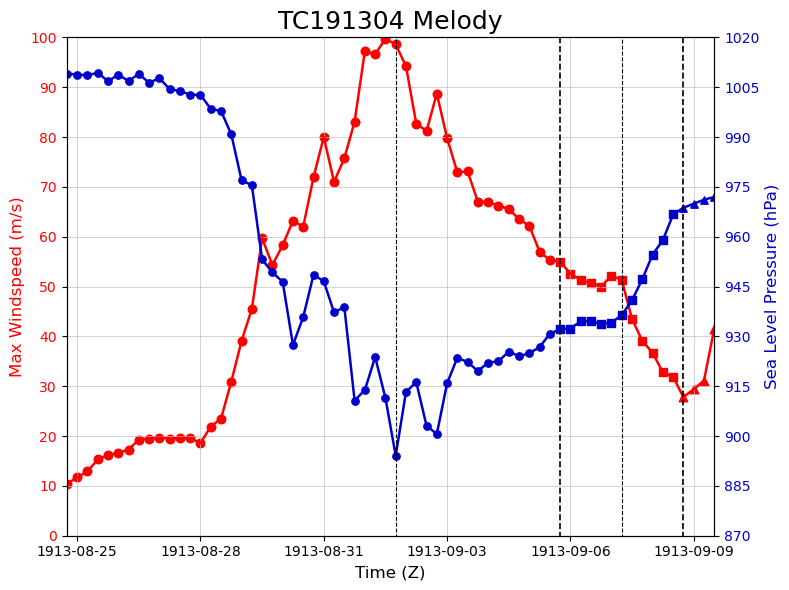

In [34]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

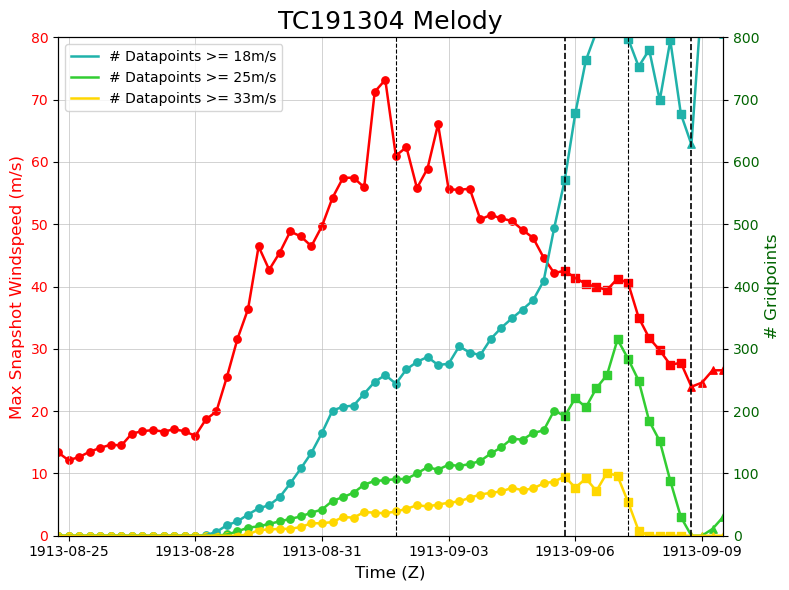

In [35]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

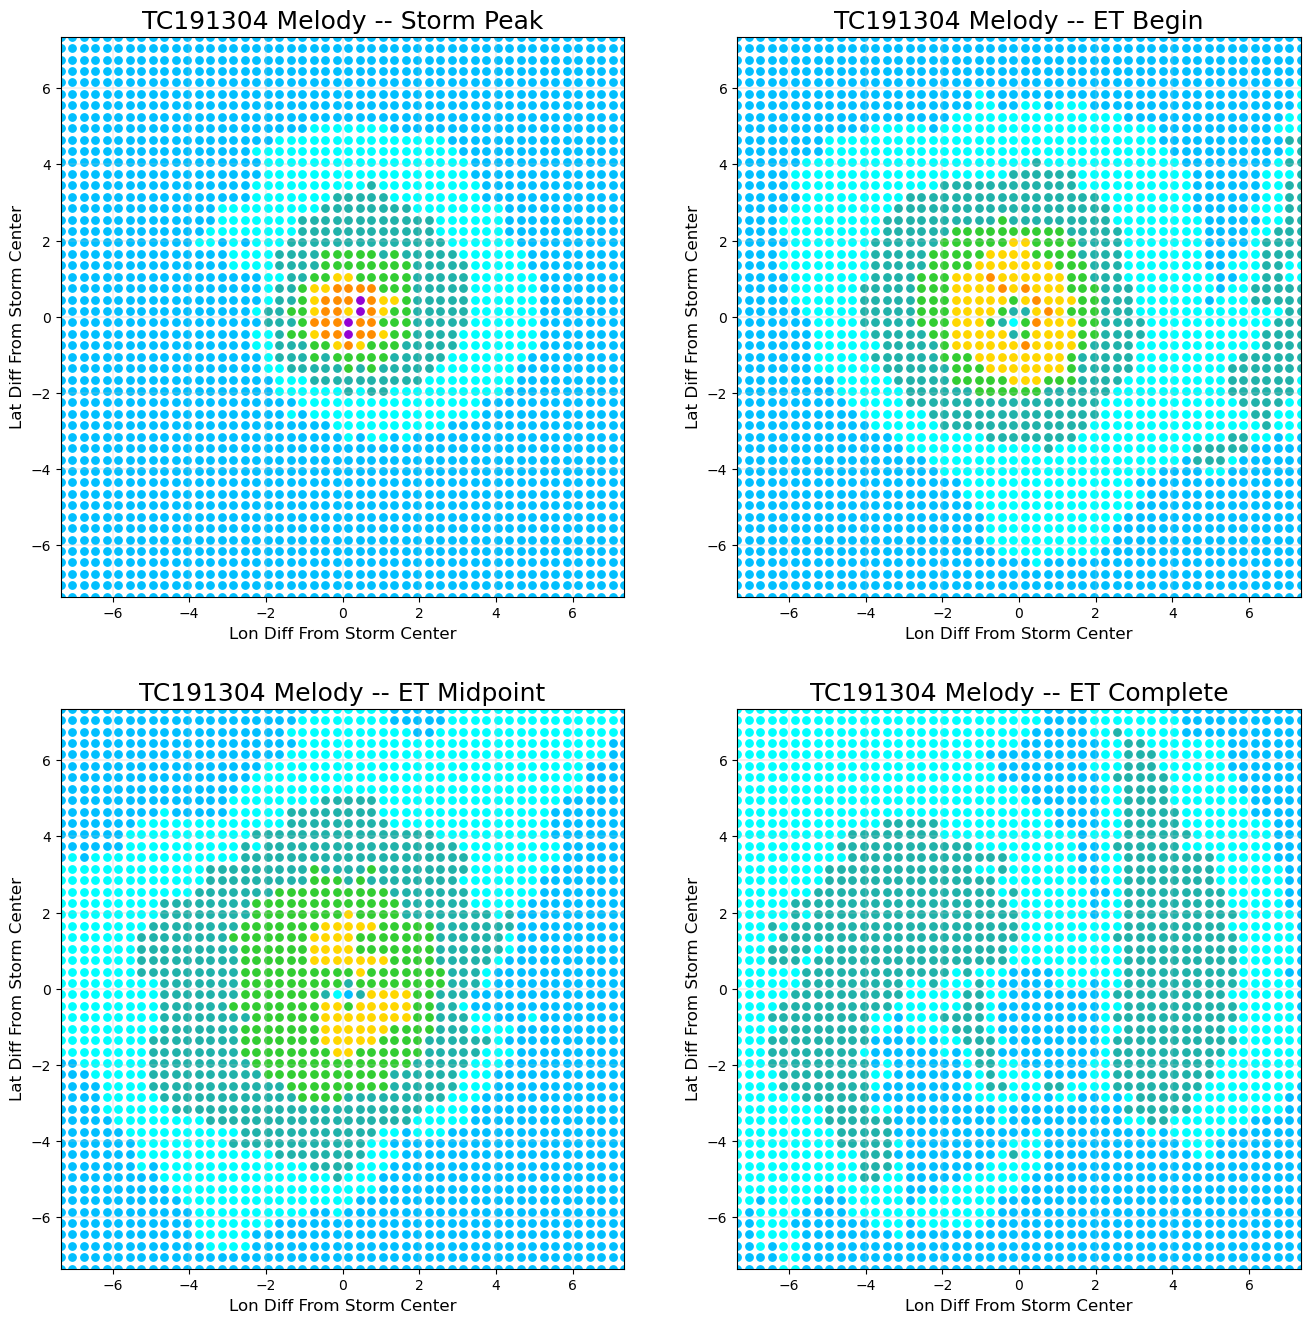

In [36]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)

In [37]:
# Find Wind Field Composite Data
Code = "TC195008"
Storm_Name = "Cissy"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_B_Compo_nc
Time_Indexes = [7105,7118,7124,7126]
Time_Labels = ["Storm Peak", "Landfall", "ET Begin", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [38]:
#DF_Storm_Compo_Wind_Field[25:40]

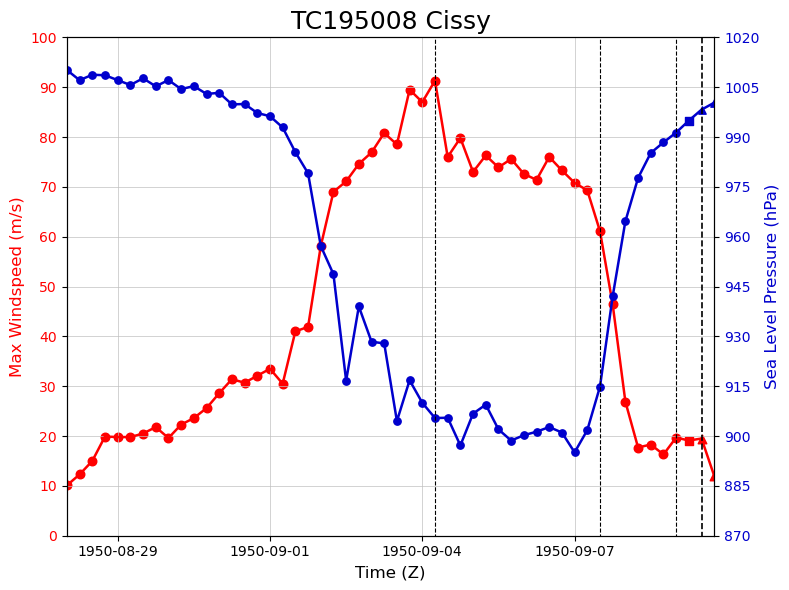

In [39]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

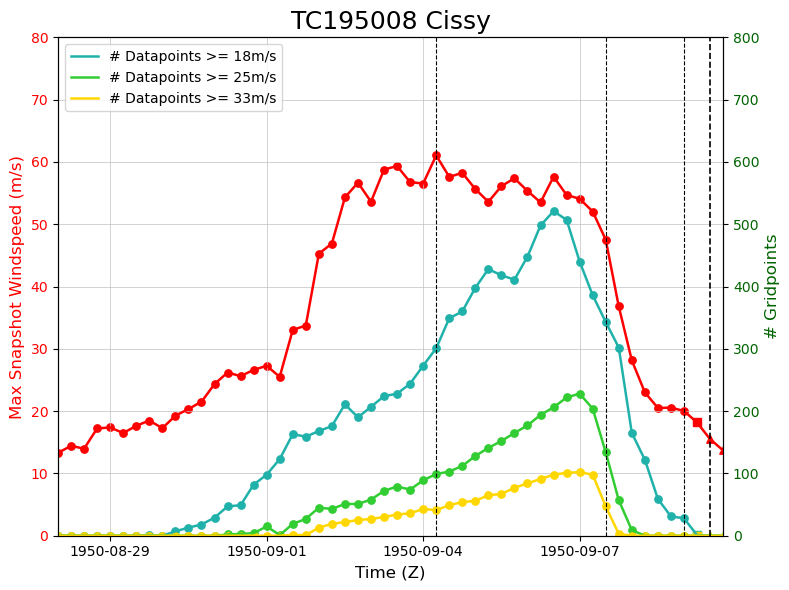

In [40]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

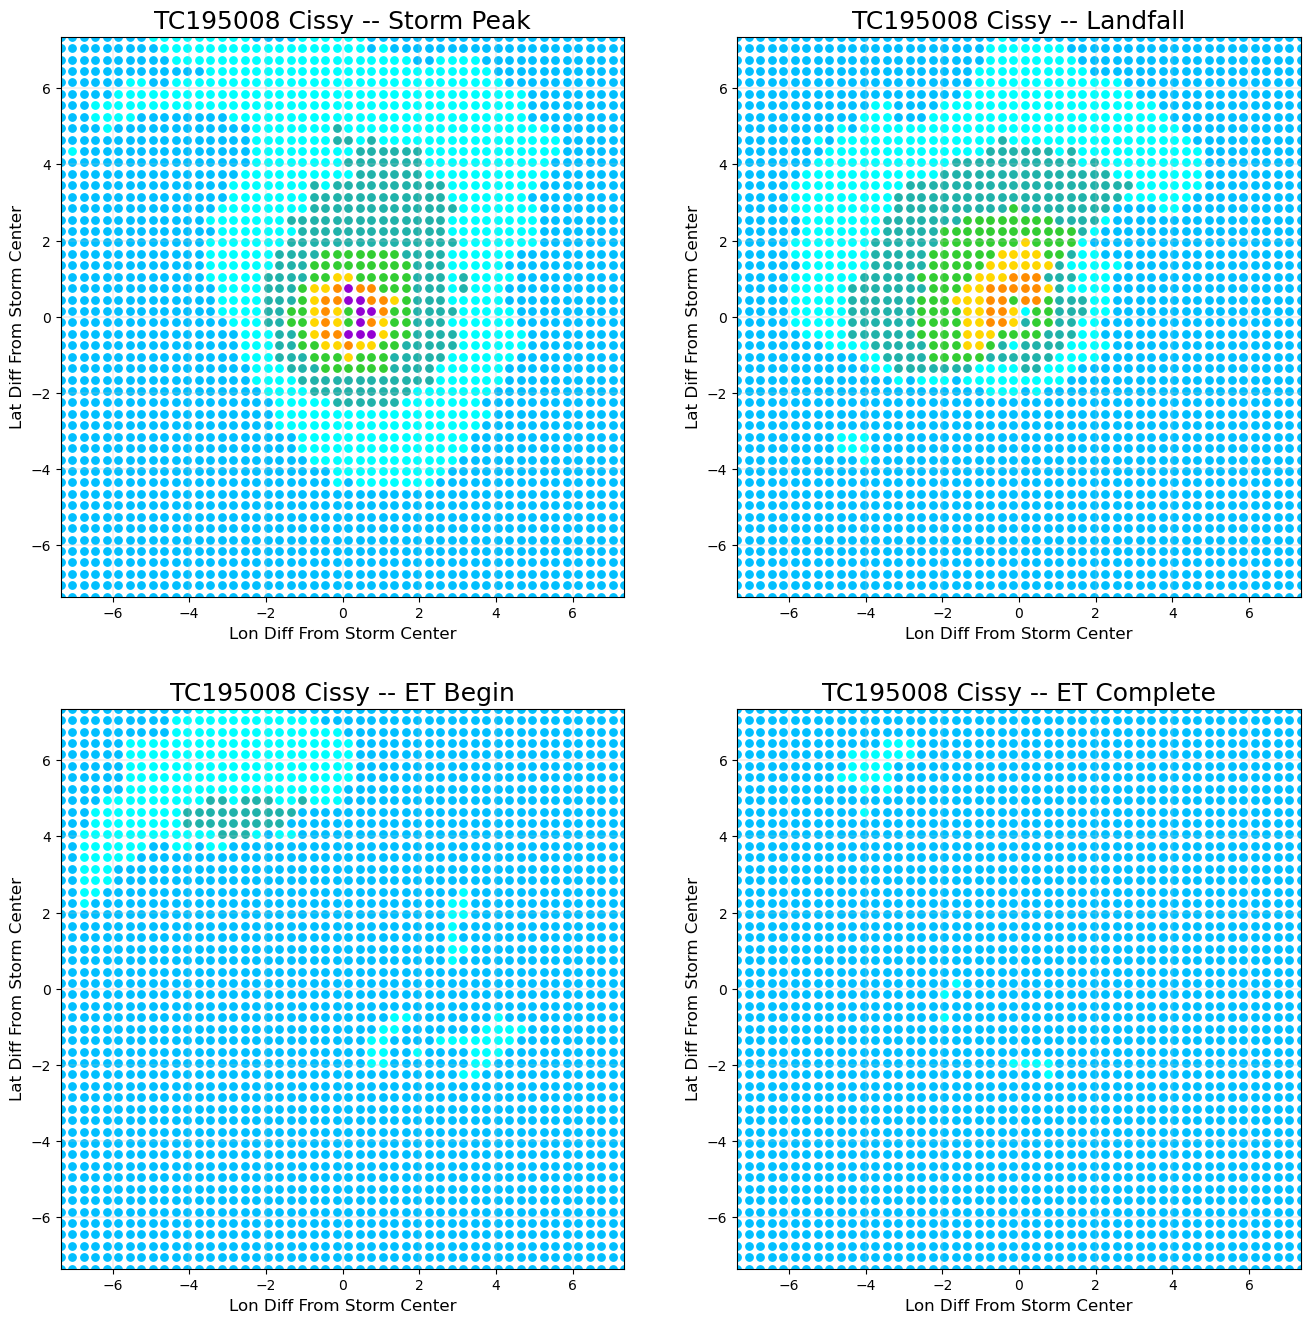

In [41]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)

In [42]:
# Find Wind Field Composite Data
Code = "TC197807"
Storm_Name = "Maho"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_C_Compo_nc
Time_Indexes = [6127,6135,6141,6147]
Time_Labels = ["Initial Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [43]:
#DF_Storm_Compo_Wind_Field[25:40]

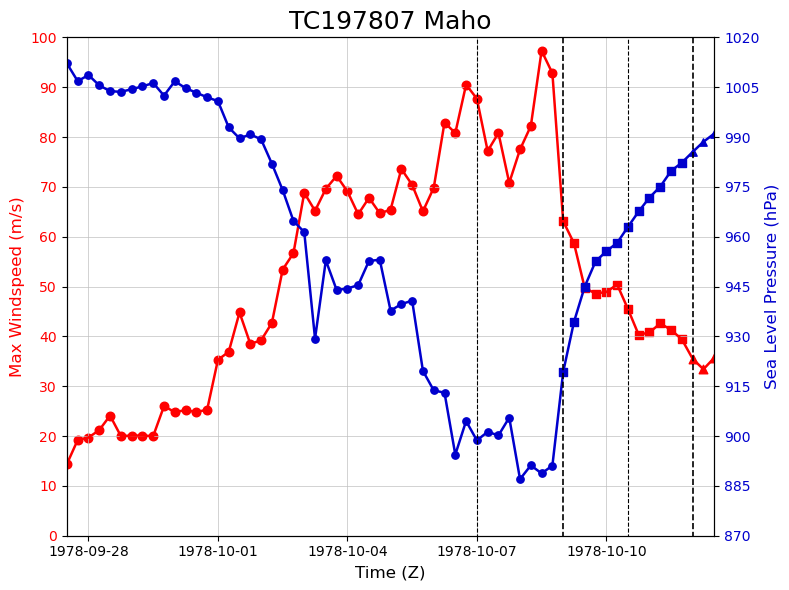

In [44]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

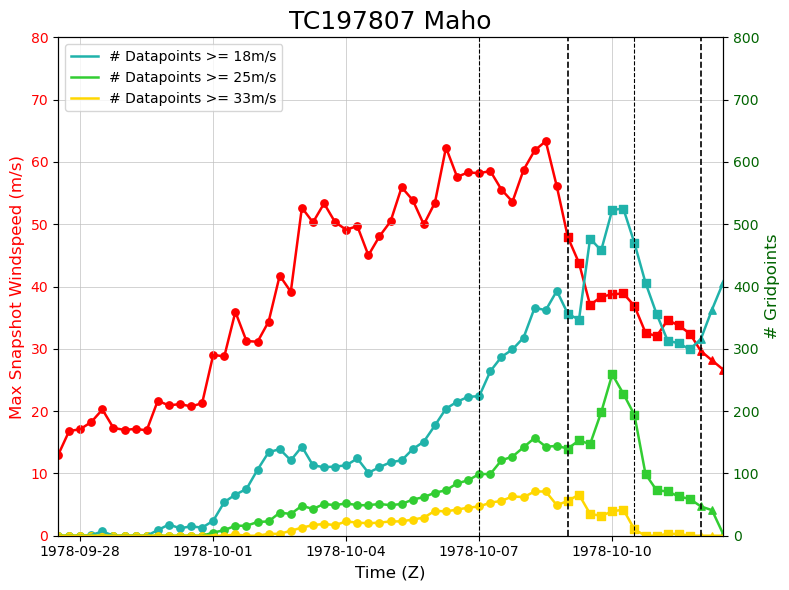

In [45]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

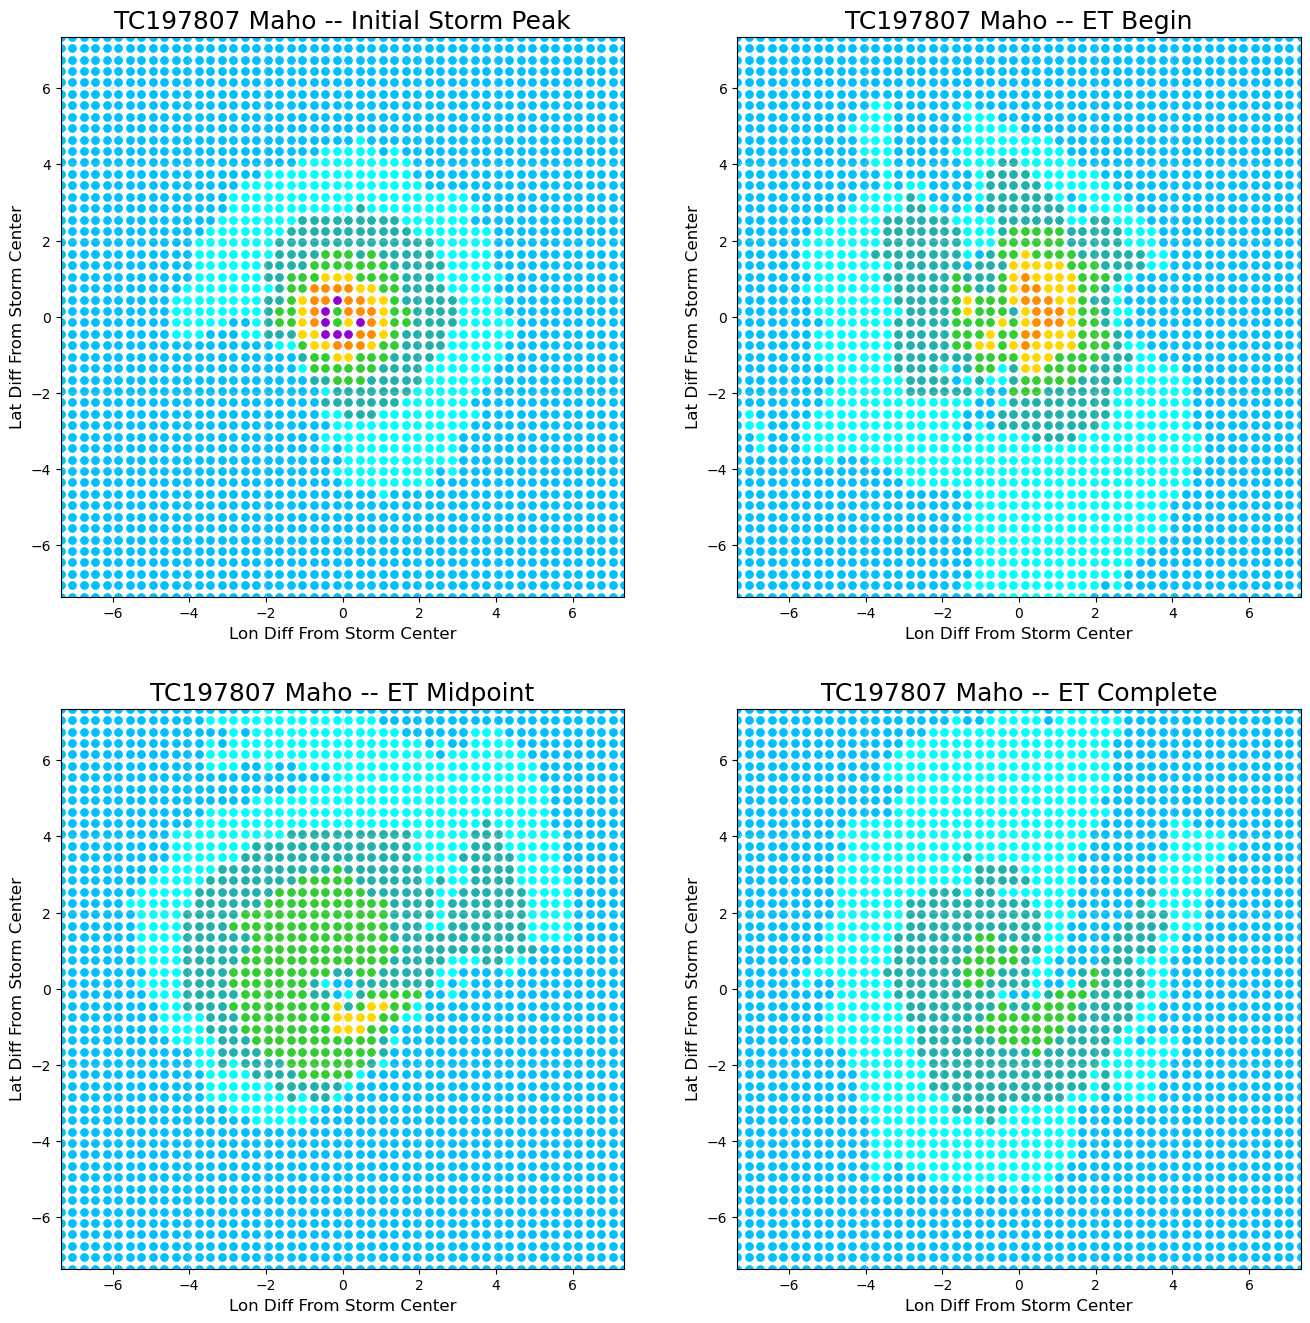

In [46]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)

In [57]:
# Find Wind Field Composite Data
Code = "TC202009"
Storm_Name = "Kinen"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_A_Compo_nc
Time_Indexes = [4776,4782,4792,4795]
Time_Labels = ["Storm Peak", "Initial ET Begin", "Actual ET Begin", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [58]:
#DF_Storm_Compo_Wind_Field

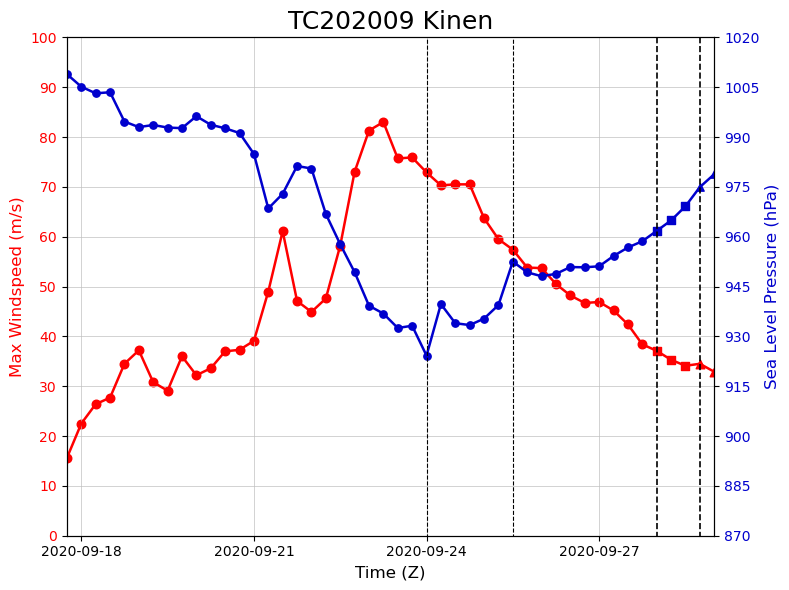

In [59]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

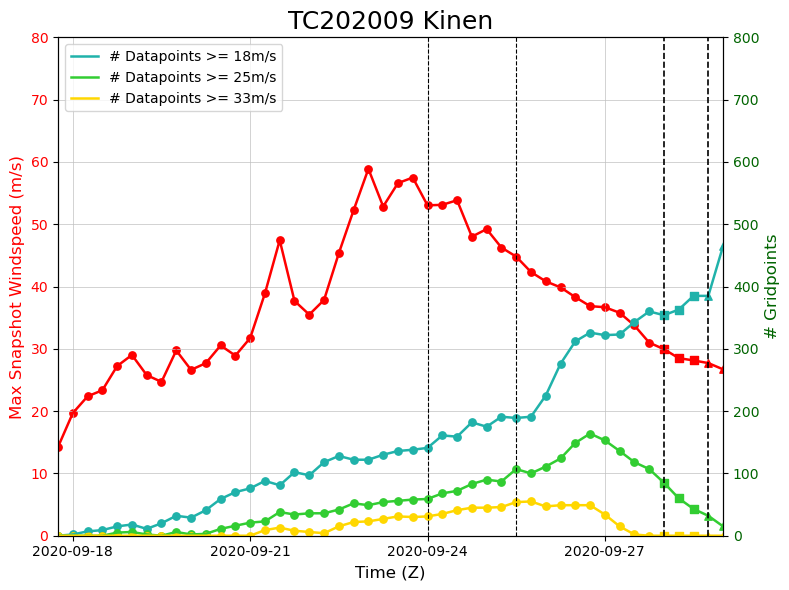

In [60]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

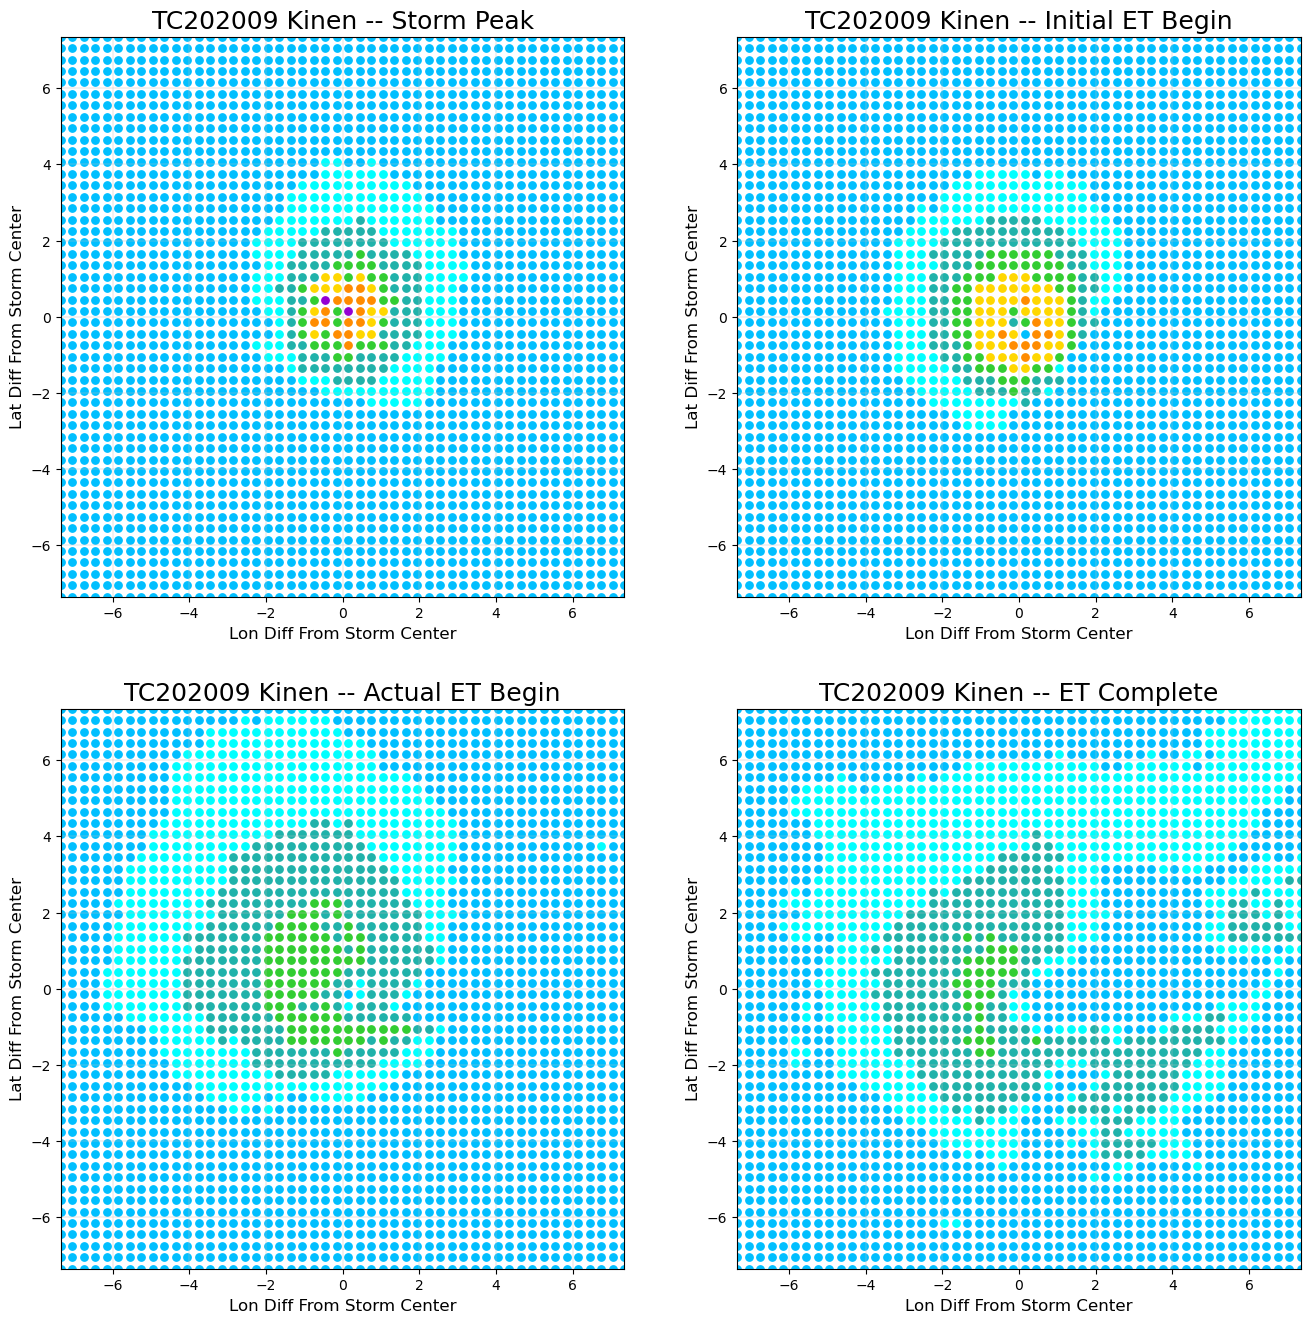

In [61]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)

In [66]:
# Find Wind Field Composite Data
Code = "TC204304"
Storm_Name = "Audrey"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_B_Compo_nc
Time_Indexes = [2476,2486,2489,2491]
Time_Labels = ["Tropical Transition", "Storm Peak", "ET Begin", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [63]:
DF_Storm_Compo

,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),Storm Phase,18m/s,25m/s,33m/s,Compo Max Wind
0,2470.0,2043-03-21 12:00:00,-59.77,36.73,1002.06,22.7,Tropical,27.0,0.0,0.0,23.368683
1,2471.0,2043-03-21 18:00:00,-58.17,37.35,995.49,26.8,Tropical,88.0,2.0,0.0,28.811527
2,2472.0,2043-03-22 00:00:00,-56.57,37.96,988.91,30.8,Tropical,212.0,1.0,0.0,26.568907
3,2473.0,2043-03-22 06:00:00,-54.97,38.58,982.34,34.8,Tropical,530.0,16.0,0.0,27.867910
4,2474.0,2043-03-22 12:00:00,-53.37,39.19,975.76,38.8,Tropical,706.0,80.0,0.0,31.735260
5,2475.0,2043-03-22 18:00:00,-51.84,38.94,973.32,32.8,Tropical,859.0,99.0,0.0,29.138559
6,2476.0,2043-03-23 00:00:00,-50.37,39.47,972.33,32.0,Tropical,937.0,114.0,0.0,31.020191
7,2477.0,2043-03-23 06:00:00,-49.55,39.39,971.24,37.4,Tropical,1134.0,196.0,0.0,31.447546
8,2478.0,2043-03-23 12:00:00,-48.13,38.05,972.18,34.8,Tropical,1467.0,260.0,0.0,30.536608
9,2479.0,2043-03-23 18:00:00,-45.90,37.78,971.24,32.2,Tropical,1596.0,294.0,0.0,28.952322


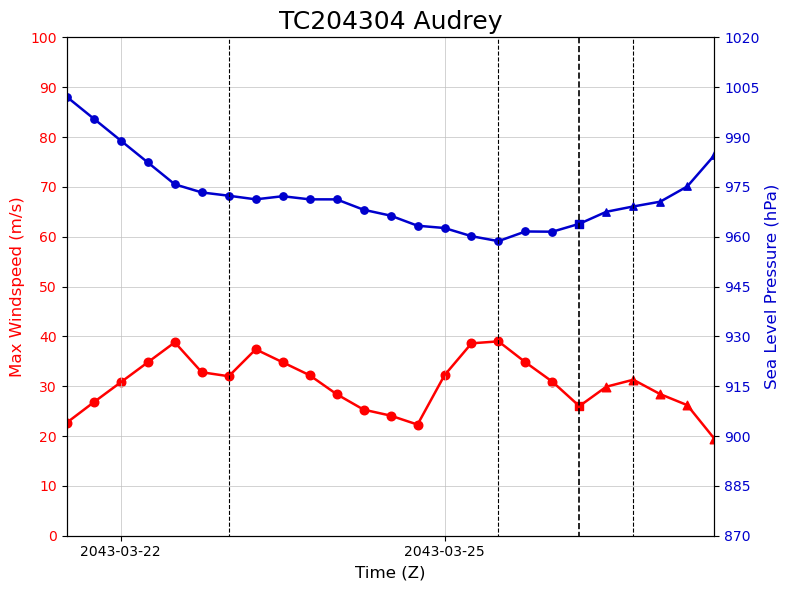

In [67]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

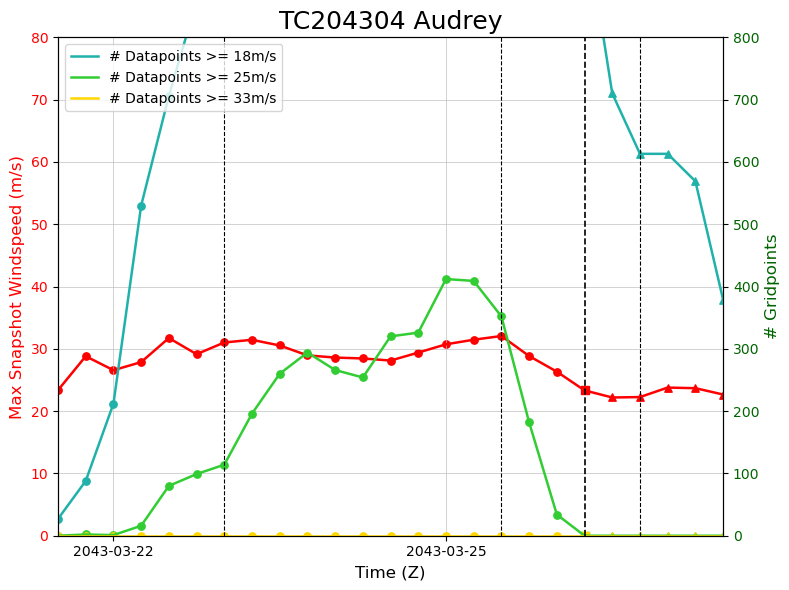

In [68]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

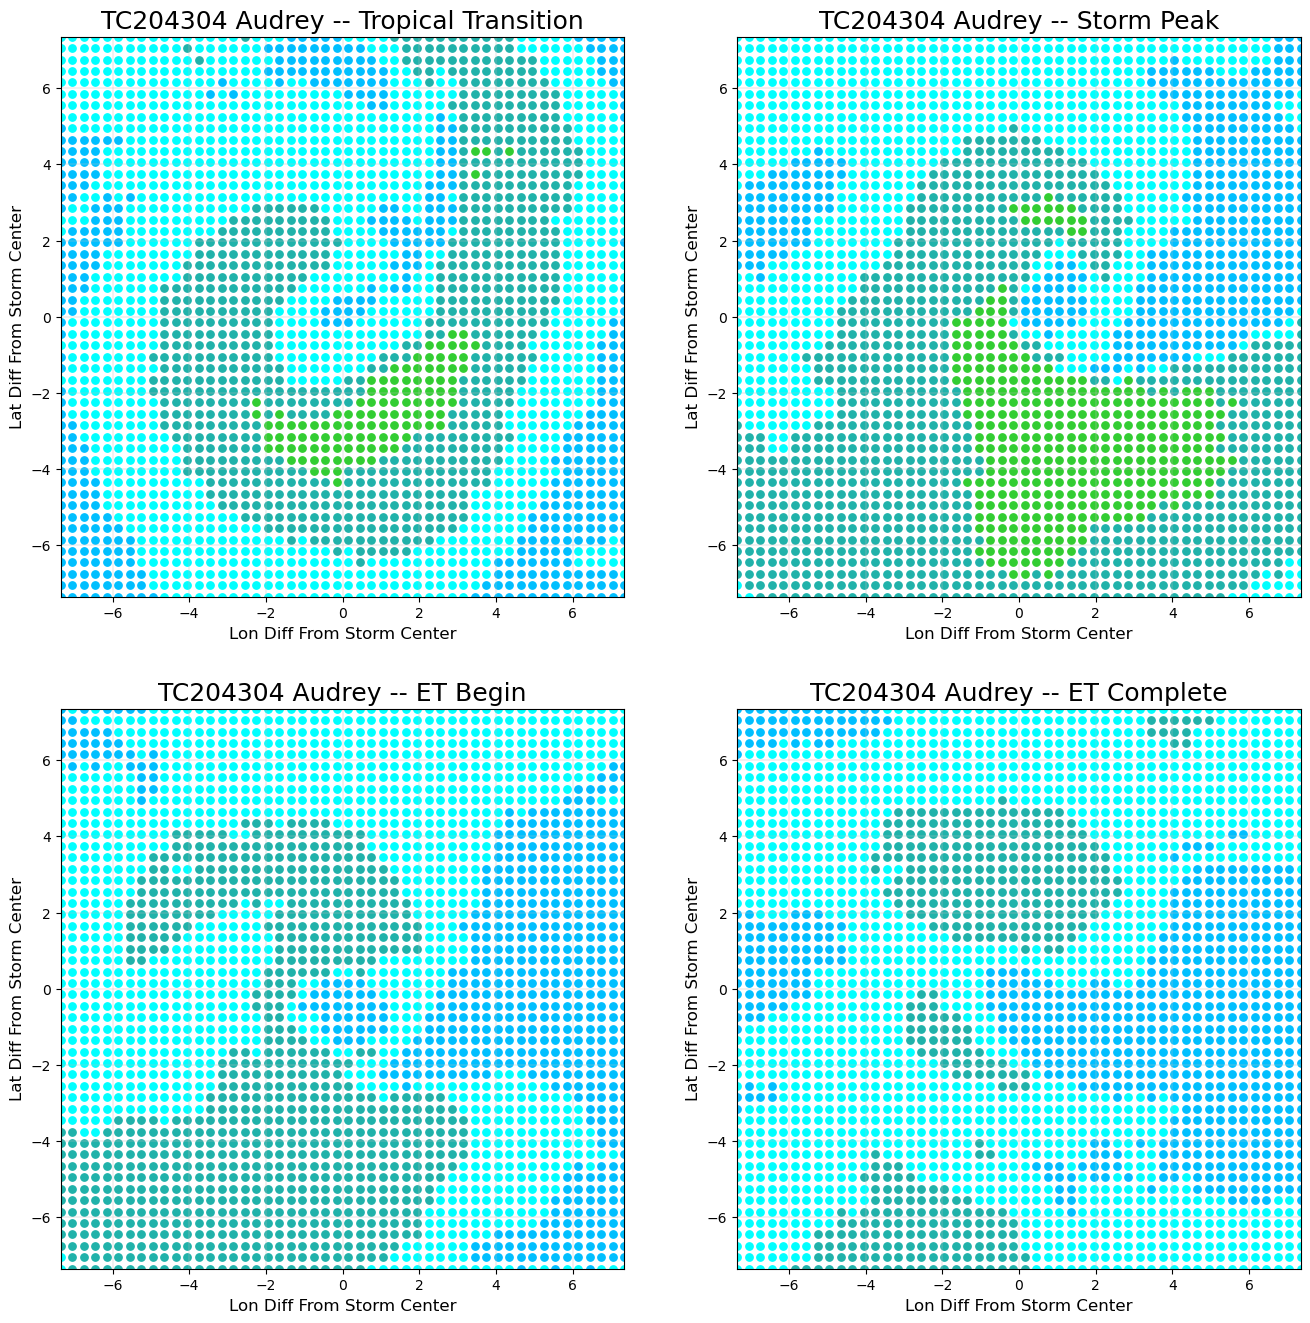

In [69]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)

In [74]:
# Find Wind Field Composite Data
Code = "TC208507"
Storm_Name = "Song"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_C_Compo_nc
Time_Indexes = [5818,5826,5828,5830]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [77]:
#DF_Storm_Compo

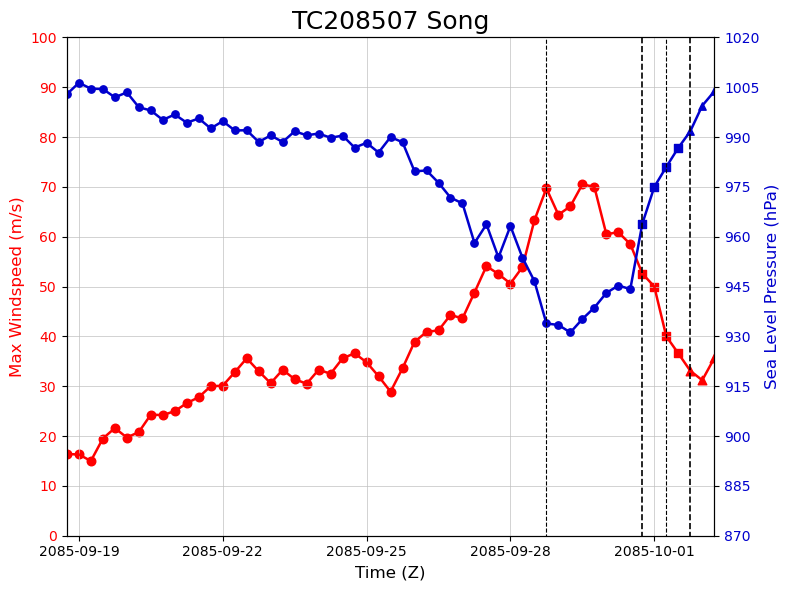

In [75]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

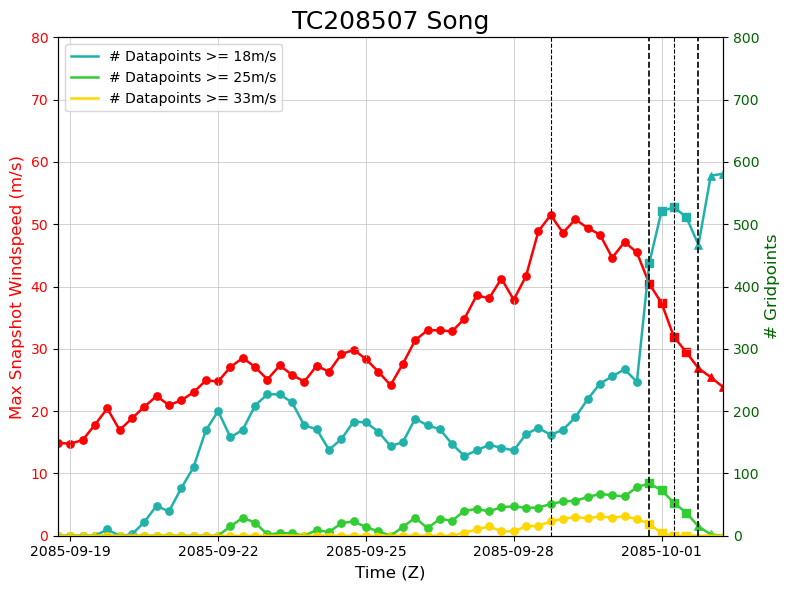

In [76]:
# Plot Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)

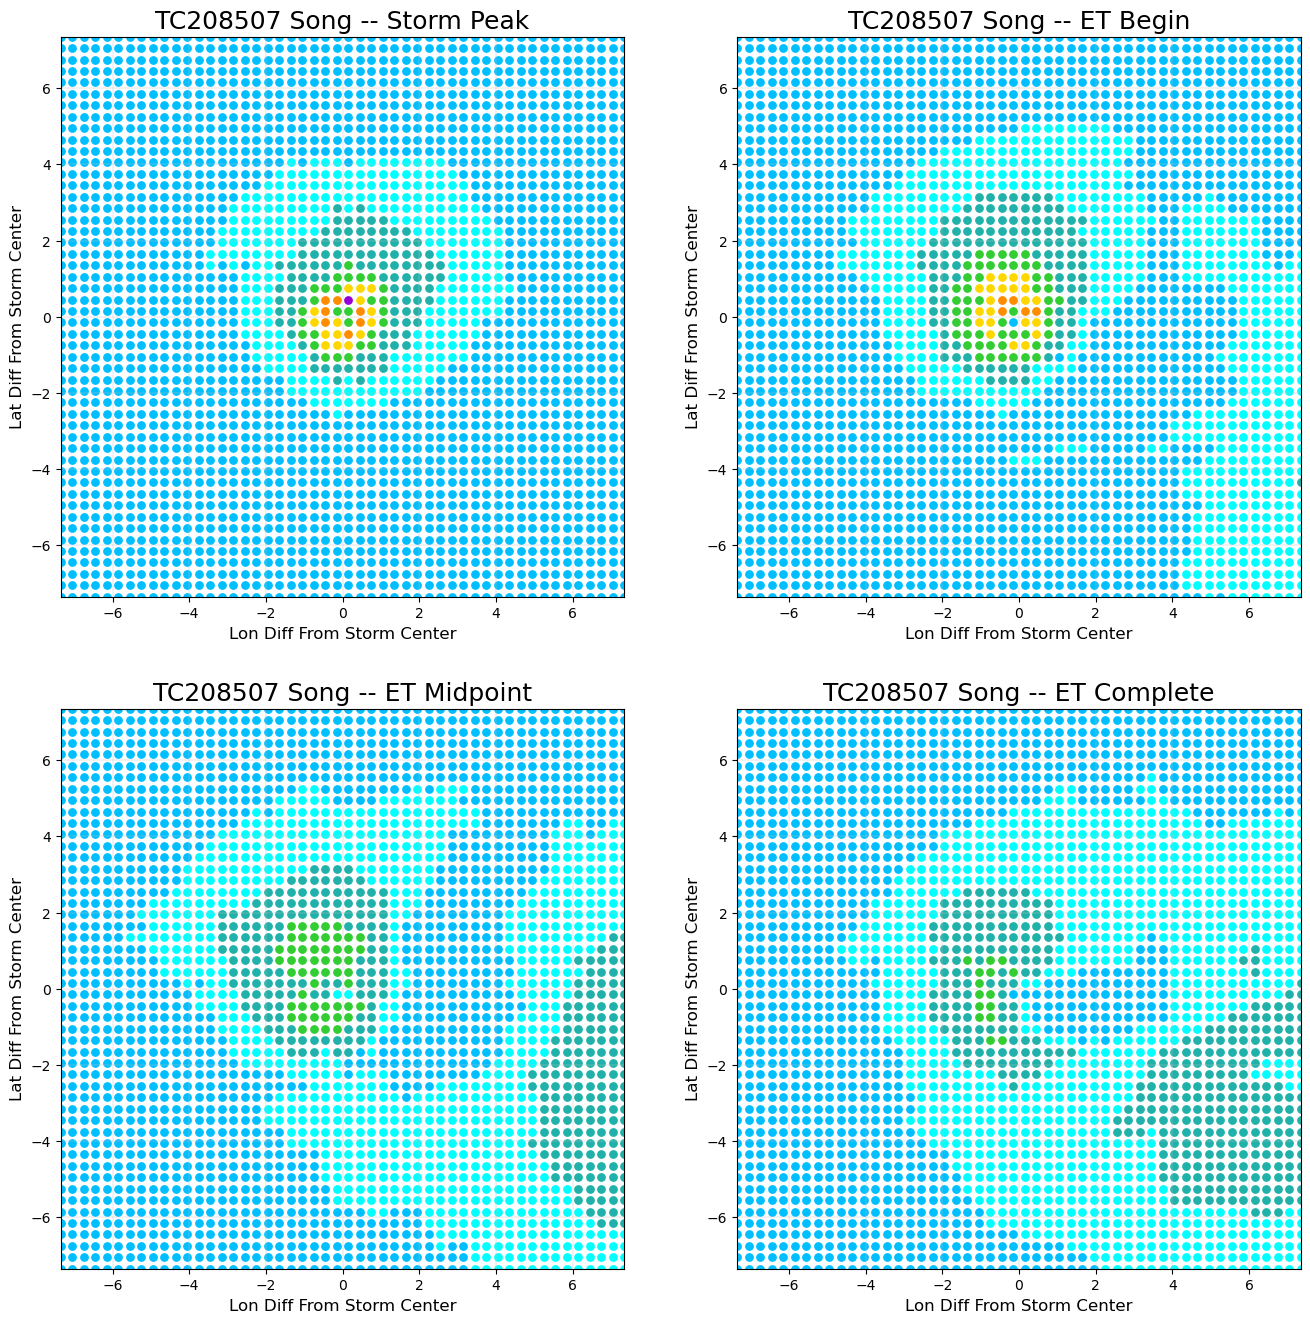

In [73]:
# Plot Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels)